Twitter Stock Dataset on Kaggle: https://www.kaggle.com/datasets/maharshipandya/twitter-stocks-dataset


Task: Predict the stock movement (up or down) of Twitter stock based on it's previous Adjusted closing price using Linear, Ridge and Logistic regression.

The stock market is subject to an uncountable number of effects which can move a stock's price up and down. My goal is to predict whether Twitter stock's opening price will go up or down using Linear Regression, Ridge Regression, and Logistic Regression and comparing the 3 methods. My main focus is using regression but I used Logistic regression just to try a binary classifier and see the result compared to the regression algorithms. For Linear and Ridge regression, my independant variable will be Adj Closing and the predicted variable will be Open.

In [89]:
# import statements
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from pandas import Series
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import seaborn as san
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from itertools import chain

In [ ]:
# Load dataset
#from google.colab import files
#dataset = files.upload()

In [ ]:
stockdata = pd.read_csv('twitter-stocks.csv')

**2.1 (a) Brief Exploration of the dataset:**


There are no categorical variables. There are 6 raw features: Open, High, Low, Close, Adj Close, and Volume. There are 2259 samples. There are no missing values.

2259
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2259 non-null   object 
 1   Open       2259 non-null   float64
 2   High       2259 non-null   float64
 3   Low        2259 non-null   float64
 4   Close      2259 non-null   float64
 5   Adj Close  2259 non-null   float64
 6   Volume     2259 non-null   float64
dtypes: float64(6), object(1)
memory usage: 123.7+ KB


Text(0.5, 1.0, 'Adj Close')

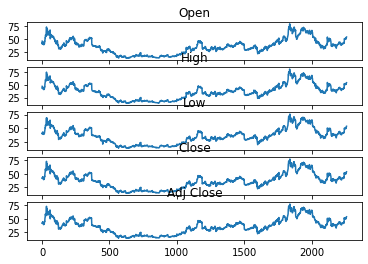

In [ ]:
# Number of Samples
print(stockdata.shape[0])

# All df info
stockdata.info()

#Graphs of the data with time on X and price on Y
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
ax1.plot(stockdata.iloc[1:2259]["Open"])
ax1.set_title("Open")
ax2.plot(stockdata.iloc[1:2259]["High"])
ax2.set_title("High")
ax3.plot(stockdata.iloc[1:2259]["Low"])
ax3.set_title("Low")
ax4.plot(stockdata.iloc[1:2259]["Close"])
ax4.set_title("Close")
ax5.plot(stockdata.iloc[1:2259]["Adj Close"])
ax5.set_title("Adj Close")

**2.1 (b) Pre-processing of each dataset:** *Carry out preprocessing of each dataset, which should be guided
by your exploration of the dataset as well as your forthcoming plans for the datasets. This preprocessing could
involve, e.g., replacement of invalid entries with plausible values, centering of the data, standardization of
the data, encoding of categorical variables, etc. All of the preprocessing steps should be fully motivated and
justified in markdown cells.*

I wrote code to fill any potentially missing values with 0, however there does not seem to be any empty values noted by the info funtion.

I carry out preprocessing in 2.1 (c) on a new df I create where I remove NaN values and encode Price Direction as 1 and 0.

In [ ]:
# Replace null values with 0

stockdata["Open"].fillna(0, inplace = True)
stockdata["High"].fillna(0, inplace = True)
stockdata["Low"].fillna(0, inplace = True)
stockdata["Close"].fillna(0, inplace = True)
stockdata["Adj Close"].fillna(0, inplace = True)
stockdata["Volume"].fillna(0, inplace = True)

**2.1 (c) Feature extraction / feature learning from each dataset:

In the following code, I change the dates in stockdata to numbers from 1 to 2259 so I can more easily access samples later on. I also add 2 columns, one for the sample to sample percent change of the opening price from the "Open" column and one to dictate whether the price went up or down from the previous day based on the "Open % Change" column. 1 means up, 0 means down. This column will come in hand when train-testing the linear model

I also created a new dataframe exclusively for the logistic model called logisticStockData. This dataframe contains the Adj Close % change as a row called "Today" to notate today's price change. I then added 5 lag variables, meaning Lag 1 is the previous day's change, Lag 2 is the change from 2 days ago, and so on. Volume was also added as an independant variable and shifted down by 1 so it becomes the volume of the previous day opposed to volume of the current day. The constant was added because in the statsmodel api, a constant is required for an intercept. So, a function is used to add a column of constants, all 1.0. All NaN values are dropped so we lose the first 5 samples, but that is not a lot in the grand scheme of 2259 samples.

In [ ]:
# Replace dates with numbers starting from 1 form the first day. Save these changes to original df. 
for i in range(len(stockdata)):
  stockdata.iloc[i,0] = i+1
stockdata['Open % Change'] = stockdata['Open'].pct_change() * 100
stockdata['Open Price Direction'] = [1 if i > 0 else 0 for i in stockdata['Open % Change']]
print(stockdata.head(10))
# Create new DF of avgs of Open, High, Low, Adj Close
avgStockdata = pd.DataFrame(index=range(len(stockdata)),columns=range(2))

for i in range(len(stockdata)):
  rowMean = (stockdata.iloc[i,1] + stockdata.iloc[i,2] + stockdata.iloc[i,3] + stockdata.iloc[i,5]) / 5
  avgStockdata.iloc[i, 0] = i + 1
  avgStockdata.iloc[i, 1] = rowMean

#I created the following DF for performing logistic regression on later.
logisticStockData = stockdata['Adj Close'].pct_change() * 100
logisticStockData = logisticStockData.rename("Today")
logisticStockData = logisticStockData.reset_index()
for i in range(1,6):
  logisticStockData['Lag '+str(i)] = logisticStockData['Today'].shift(i)
logisticStockData['Volume'] = stockdata.Volume.shift(1).values #get the volumes, but shift so each value corresponds to previous day's volume
logisticStockData = logisticStockData.dropna()
logisticStockData['Price Direction'] = [1 if i > 0 else 0 for i in logisticStockData['Today']]
logisticStockData = sm.add_constant(logisticStockData)
logisticStockData.head(10)

  Date       Open       High        Low      Close  Adj Close       Volume  \
0    1  45.099998  50.090000  44.000000  44.900002  44.900002  117701670.0   
1    2  45.930000  46.939999  40.685001  41.650002  41.650002   27925307.0   
2    3  40.500000  43.000000  39.400002  42.900002  42.900002   16113941.0   
3    4  43.660000  43.779999  41.830002  41.900002  41.900002    6316755.0   
4    5  41.029999  42.869999  40.759998  42.599998  42.599998    8688325.0   
5    6  42.340000  45.669998  42.240002  44.689999  44.689999   11099433.0   
6    7  45.250000  45.270000  43.430000  43.980000  43.980000    8010663.0   
7    8  43.500000  43.950001  40.849998  41.139999  41.139999   12810624.0   
8    9  41.389999  41.900002  40.000000  41.750000  41.750000    7436616.0   
9   10  41.400002  41.750000  40.509998  41.049999  41.049999    5767325.0   

   Open % Change  Open Price Direction  
0            NaN                     0  
1       1.840359                     1  
2     -11.822338  

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,index,Today,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Volume,Price Direction
6,1.0,6,-1.588720,4.906106,1.670635,-2.331002,3.001200,-7.238307,11099433.0,0
7,1.0,7,-6.457483,-1.588720,4.906106,1.670635,-2.331002,3.001200,8010663.0,0
8,1.0,8,1.482744,-6.457483,-1.588720,4.906106,1.670635,-2.331002,12810624.0,1
9,1.0,9,-1.676649,1.482744,-6.457483,-1.588720,4.906106,1.670635,7436616.0,0
10,1.0,10,2.460419,-1.676649,1.482744,-6.457483,-1.588720,4.906106,5767325.0,1
11,1.0,11,-2.520212,2.460419,-1.676649,1.482744,-6.457483,-1.588720,8324753.0,0
12,1.0,12,-4.731705,-2.520212,2.460419,-1.676649,1.482744,-6.457483,6185245.0,0
13,1.0,13,2.867381,-4.731705,-2.520212,2.460419,-1.676649,1.482744,14333375.0,1
14,1.0,14,1.791941,2.867381,-4.731705,-2.520212,2.460419,-1.676649,9828433.0,1
15,1.0,15,1.638137,1.791941,2.867381,-4.731705,-2.520212,2.460419,5536322.0,1


**2.1 (d) Processing of each dataset using two different machine learning methods:** 


I used Linear and Logistic regression to determine the price change (Up or Down) of the next day's stock price given the previous days' stock prices. 

For Linear regression, I drew a best fit line to the Adj Close vs Open graph and used this line to predict future values. I found the best fit line using the least squares method and found a slope and y intercept. I created a function to do this. The function intakes a start date, and end date, independant variable column name, and dependant variable column name. I chose "Adj Close" to be the independant variable and "Open" as the dependent variable. Essentially, I saw the next day's opening price dependant on where the price closed at previously. This relationship shows a strong R squared value of 0.995 when trained across all the values, and a scatterplot with a red line of best fit is shown as an example. I also predicted all the values of the Opening price using the linear model in the next plot where the Green line is the original data and the Orange plot is the predicted data. The lines match up from a distant view, but I used Cross Validation to deeply analyze the true success of whether a linear model can successfully predict upwards and downwards movement. I used

Next, I carried out Logistic regression with the help of the statsmodel api and sklearn api. I used the following independant variables: 'const', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', and 'Volume'. The binary variable I am predicting was the 'Price Direction'. It can be 1 for up or 0 for down I created a confusion matrix afterwards and calculated the success rate of the model by adding TP and TN then dividing by TP+FP+FN+TN.I also train tested the data on 80% as training data and 20% as testing data.

Finally, I carried out Ridge regression using sklearn. I used Adj Close as the independent variable and predicted Open. I skipped using the train_test_split function and opted to just split the data into roughly 80% training and 20% testing data. This proved to be successful and I could easily graph my results to get a visual display on the rpedicted values versus the real values. I created a list of potential alpha values and used GridSearchCV to find the best alpha value. Finally, I created Open predictions given X_test.

{'slope': 0.9994261968282621, 'yint': 0.037235583619458355, 'n': 2258, 'Rsqrd': 0.9948343793271067}


<Figure size 720x360 with 0 Axes>

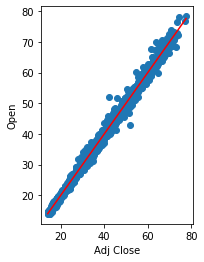

In [ ]:
# Least-Squares Regression


#Plot all data for a visual
plt.figure(figsize=(10,5))

fig = plt.figure()
ax1 = fig.add_subplot(121)

def LSR_xVSy(date1, date2, xData, yData):
  n = date2 - date1 + 1
  sumX = sum(stockdata.iloc[date1:date2 + 1][xData])
  sumY = sum(stockdata.iloc[date1:date2 + 1][yData])
  sumXY = 0
  sumXsqrd = 0
  for x in range(n):
    sumXY += stockdata.iloc[date1 + x][xData] * stockdata.iloc[date1 + x][yData]
    sumXsqrd += (stockdata.iloc[date1 + x][xData]) ** 2
  slope = ((n * sumXY) - (sumX*sumY)) / ((n * sumXsqrd) - sumX**2)
  yint =  (sumY - (slope * sumX)) / n

  x = np.linspace(min(stockdata.iloc[date1:date2 + 1][xData]), max(stockdata.iloc[date1:date2 + 1][xData]))
  y = slope * x + yint
  
  ax1.scatter(stockdata.iloc[date1:date2 + 1][xData],stockdata.iloc[date1:date2 + 1][yData])
  ax1.set_xlabel(xData)
  ax1.set_ylabel(yData)
  ax1.plot(x,y,color='r')

  # Calculate R squared value
  #Step 1: Calculate xData values Mean
  meanX = sumX / n
  
  #Step 2: Calculate yData values Mean
  meanY = sumY / n
  #Step 3: Find SSmean, VarMean, SSfit, varFit and then R squared
  SSmeanY = sum((stockdata.iloc[date1:date2 + 1][yData] - meanY)**2)
  VarMean = SSmeanY / n
  SSfit = 0
  for i in range(n):
    xPoint = stockdata.iloc[date1+i][xData]
    yPoint = stockdata.iloc[date1+i][yData]
    yPredicted = slope * xPoint + yint
    SSfit += (yPoint - yPredicted)**2 
  VarFit = SSfit/n
  Rsqrd = (VarMean - VarFit) / VarMean
  return {"slope": slope, "yint": yint, "n": n, "Rsqrd": Rsqrd}
date1 = 1
date2 = 2258
LSRobj = LSR_xVSy(date1, date2, "Adj Close", "Open")
print(LSRobj)

As shown in the code above, there is a high correlation between the closing price and opening price of Twitter stock. Across all the data, the R squared value shows 99.48%.

Given the Closing price of one day, predict the opening price of the next day.

1       45.930000
2       40.500000
3       43.660000
4       41.029999
5       42.340000
          ...    
2254    50.000000
2255    50.709999
2256    52.415001
2257    52.950001
2258    53.910000
Name: Open, Length: 2258, dtype: float64
[41.663338680368966, 42.91262142640429, 41.91319522957603, 42.61278956965103, 44.70159132044829, 43.991999720126415, 41.15362832170796, 41.7632793011994, 41.063679963993415, 42.07310242164235, 41.0137096535782, 39.074823831157566, 40.194180172179024, 40.913769032747766, 41.58338258577031, 40.79383489084978, 41.38349634697846, 43.70216512362003, 45.631057683498575, 44.96144413047603, 49.14903789633406, 51.99740555557319, 52.34720272561069, 55.33548905297959, 59.00338119648692, 56.61475358549357, 56.45484539400105, 55.51538177070389, 57.49424963812863, 60.01279965643107, 64.5402033263417, 69.95709131429848, 73.30516807424695, 63.75065563142116, 60.512512754845204, 63.65071501059073, 67.49850386952716, 68.99764316476954, 66.28919917079115, 61.46196864125

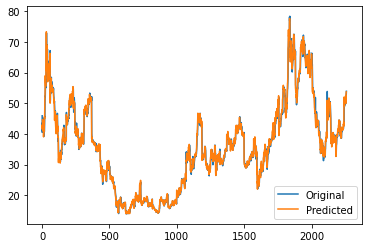

In [39]:
date1 = 1
date2 = 2258
plt.plot(stockdata.iloc[date1:date2 + 1]["Open"])
predictedOpeningPrices = []
n = date2 - date1 + 1
for i in range(n):
  closingPrice = stockdata.iloc[date1+i]["Adj Close"]
  nextPrice = LSRobj["slope"] * closingPrice + LSRobj["yint"]
  predictedOpeningPrices.append(nextPrice)
plt.plot(predictedOpeningPrices)
plt.legend(('Original', 'Predicted'))
print(stockdata.iloc[date1:date2 + 1]["Open"])
print(predictedOpeningPrices)

Moving on to Logistic Regression below.

In [115]:
#Defining the Independent (X) and Dependent (y) variables.
X = logisticStockData[['const', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'Volume']]
y = logisticStockData['Price Direction']

#I split the data into training and testing data just like in the Kaggle code example.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
#X_train = X[1:1800]
#y_train = y[1:1800]
#X_test = X[1801:2250]
#y_test = y[1801:2250]


# Here, I use the statsmodel api to perform Logistic Regression on the training data
model = sm.Logit(y_train,X_train)
result = model.fit()
#result.summary()
#I create a prediction based on the independant testing variables
prediction = result.predict(X_test)
print(prediction)

#Confusion Matrix
def confusion_matrix(act, pred):
  predtrans = ['Up' if i > 0.5 else 'Down' for i in pred]
  actuals = ['Up' if i > 0 else 'Down' for i in act]
  confusion_matrix = pd.crosstab(pd.Series(actuals), pd.Series(predtrans), rownames = ['Actual'], colnames = ['Predicted'])
  return confusion_matrix



Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 4
1594    0.490755
535     0.506490
2102    0.511956
350     0.506617
1451    0.536298
          ...   
108     0.510205
150     0.512051
1936    0.520735
1281    0.505547
1246    0.508326
Length: 451, dtype: float64


Here, I am executing Ridge Regression

Best Alpha:  1e-20
Best Score:  -0.8362055946690873
Ridge Model score: 0.9875685012237289


<ipython-input-146-306467c1babc>:27: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=10)



Prediction Values vs Actual Values
   Open Prediction
0        53.858367
1        53.239363
2        52.310866
3        51.462234
4        48.167552
5        47.029390
6        47.209100
7        45.781405
8        45.172387
9        45.921178
           Open
1801  53.410000
1802  53.270000
1803  52.220001
1804  52.500000
1805  47.090000
1806  48.549999
1807  48.090000
1808  47.660000
1809  46.099998
1810  45.590000


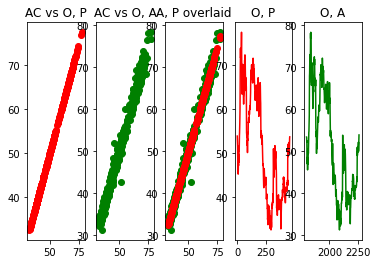

In [146]:
Xridge = stockdata[['Adj Close']] #['High', 'Low', 'Volume', 
yridge = stockdata[['Open']]

#X_train, X_test, y_train, y_test = train_test_split(Xridge, yridge, test_size=0.2)

X_train = Xridge[1:1800]
y_train = yridge[1:1800]
X_test = Xridge[1801:2259]
y_test = yridge[1801:2259]

ridge=Ridge()
parameters={'alpha':[1e-20,1e-19,1e-18,1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train,y_train)

print("Best Alpha: ",ridge_regressor.best_params_['alpha'])
print("Best Score: ",ridge_regressor.best_score_)

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

ridge_model_score = ridge_model.score(X_test, y_test)
print('Ridge Model score:', ridge_model_score)

openPredictionRidge = ridge_model.predict(X_test)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.tight_layout(pad=10)
ax1.scatter(X_test, openPredictionRidge, color='r')
ax1.set_title('AC vs O, P') # Adj Close vs Open, predicted
ax2.scatter(X_test, y_test, color='g') 
ax2.set_title('AC vs O, A') # Adj Close vs Open, Actual
ax3.scatter(X_test, y_test, color='g')
ax3.scatter(X_test, openPredictionRidge, color='r')
ax3.set_title('A, P overlaid')
ax4.plot(openPredictionRidge, color='r')
ax4.set_title('O, P') # Open Prediction
ax5.plot(y_test, color='g')
ax5.set_title('O, A') # Open Actual

print("")
print("Prediction Values vs Actual Values")
openPredictionRidge = list(chain.from_iterable(openPredictionRidge))
openPredictionRidgedf = pd.DataFrame (openPredictionRidge, columns = ['Open Prediction'])
print(openPredictionRidgedf.head(10))
print(y_test.head(10))

**2.1 (e) Comparative analysis of the two methods on each dataset:

In [145]:
# Logistic Regression
print("Below is the Logistic Regression Confusion Matrix")
print(confusion_matrix(y, prediction))
print("Accuracy Rate of Logistic Regression: ",(40+189)/(40+33+189+189))

#Ridge Regression
y_test_r = stockdata[1801:2259]
openPredictionRidgedf['Open % Change'] = openPredictionRidgedf['Open Prediction'].pct_change() * 100
openPredictionRidgedf['Open Price Direction'] = [1 if i > 0 else 0 for i in openPredictionRidgedf['Open % Change']]

TPcounterRidge = 0
FNcounterRidge = 0
FPcounterRidge = 0
TNcounterRidge = 0

for i in range(len(openPredictionRidgedf)):
  if(y_test_r.iloc[i,8] == 1): 
    if(openPredictionRidgedf.iloc[i,2] == 1): TPcounterRidge += 1
    elif(openPredictionRidgedf.iloc[i,2] == 0): FNcounterRidge += 1
  if(y_test_r.iloc[i,8] == 0):
    if(openPredictionRidgedf.iloc[i,2] == 1): FPcounterRidge += 1
    elif(openPredictionRidgedf.iloc[i,2] == 0): TNcounterRidge += 1
print("")
print("TPcounterRidge: ", TPcounterRidge)
print("FNcounterRidge: ", FNcounterRidge)
print("FPcounterRidge: ", FPcounterRidge)
print("TNcounterRidge: ", TNcounterRidge)
print("Accuracy of Ridge Regression: ", (TPcounterRidge + TNcounterRidge)/(TPcounterRidge + TNcounterRidge + FNcounterRidge + FPcounterRidge))
print("")

#Cross validate across samples 1-2000 with 5 folds
obj1 = LSR_xVSy(401,2000, "Adj Close", "Open")

obj2 = LSR_xVSy(1,400, "Adj Close", "Open") 
obj3 = LSR_xVSy(801,2000, "Adj Close", "Open")

obj4 = LSR_xVSy(1,800, "Adj Close", "Open") 
obj5 = LSR_xVSy(1201,2000, "Adj Close", "Open")

obj6 = LSR_xVSy(1,1200, "Adj Close", "Open") 
obj7 = LSR_xVSy(1601,2000, "Adj Close", "Open")

obj8 = LSR_xVSy(1,1600, "Adj Close", "Open")

#1-400
def line1(x):
  
  return obj1["slope"] * x + obj1["yint"]
#401-800
def line2(x):
  avgslope = (obj2["slope"] + obj3["slope"])/2
  avgyint = (obj2["yint"] + obj3["yint"])/2
  return  avgslope * x + avgyint
#801-1200
def line3(x):
  avgslope = (obj4["slope"] + obj5["slope"])/2
  avgyint = (obj4["yint"] + obj5["yint"])/2
  return  avgslope * x + avgyint
#1201-1600
def line4(x):
  avgslope = (obj6["slope"] + obj7["slope"])/2
  avgyint = (obj6["yint"] + obj7["yint"])/2
  return  avgslope * x + avgyint
#1601-2000
def line5(x):
  return obj8["slope"] * x + obj8["yint"]

prediction1 = []
prediction2 = []
prediction3 = []
prediction4 = []
prediction5 = []
for i in range(1,400):
  closingPrice = stockdata.iloc[i]["Adj Close"]
  nextPrice = line1(closingPrice)
  prediction1.append(nextPrice)
for i in range(401,800):
  closingPrice = stockdata.iloc[i]["Adj Close"]
  nextPrice = line2(closingPrice)
  prediction2.append(nextPrice)
for i in range(801,1200):
  closingPrice = stockdata.iloc[i]["Adj Close"]
  nextPrice = line3(closingPrice)
  prediction3.append(nextPrice)
for i in range(1201,1600):
  closingPrice = stockdata.iloc[i]["Adj Close"]
  nextPrice = line4(closingPrice)
  prediction4.append(nextPrice)
for i in range(1601,2000):
  closingPrice = stockdata.iloc[i]["Adj Close"]
  nextPrice = line5(closingPrice)
  prediction5.append(nextPrice)

def CV():
  folds = [[1,400],
           [401,800],
           [801,1200],
           [1201,1600],
           [1601,2000]]
  for i in range(5):
    if(i == 0): predictedOpeningPricesdf = prediction1
    elif(i == 1): predictedOpeningPricesdf = prediction2
    elif(i == 2): predictedOpeningPricesdf = prediction3
    elif(i == 3): predictedOpeningPricesdf = prediction4
    elif(i == 4): predictedOpeningPricesdf = prediction5
    predictedOpeningPricesdf = pd.DataFrame (predictedOpeningPrices, columns = ['Predicted Opening'])
    predictedOpeningPricesdf['Open % Change'] = predictedOpeningPricesdf['Predicted Opening'].pct_change() * 100
    predictedOpeningPricesdf['Open Price Direction'] = [1 if i > 0 else 0 for i in predictedOpeningPricesdf['Open % Change']]
    TPcounter = 0
    TNcounter = 0
    FPcounter = 0
    FNcounter = 0
    for j in range(folds[i][0] - 1,folds[i][1]):
      originalPriceDirection = stockdata.iloc[j, 8] #Original Opening Price Direction data
      predictedPriceDirection = predictedOpeningPricesdf.iloc[j - folds[i][0], 2] #Predicted Opening Price Direction data

      if(originalPriceDirection == 1): 
        if(predictedPriceDirection == 1): TPcounter += 1
        elif(predictedPriceDirection == 0): FNcounter += 1
      if(originalPriceDirection == 0):
        if(predictedPriceDirection == 1): FPcounter += 1
        elif(predictedPriceDirection == 0): TNcounter += 1

    print("Linear Regression CV for fold ", i+1)
    print("Linear True Positives",TPcounter)
    print("Linear False Positives",FPcounter)
    print("Linear False Negatives",FNcounter)
    print("Linear True Negatives",TNcounter)
    print("Accuracy Rate of Linear Regression for fold ",i+1,": ",(TPcounter + TNcounter)/(TPcounter + FPcounter + FNcounter + TNcounter))
    print("----------------------------------------------------------------------------------------------------------------------------")


CV()


Below is the Logistic Regression Confusion Matrix
Predicted  Down   Up
Actual              
Down         40  189
Up           33  189
Accuracy Rate of Logistic Regression:  0.5077605321507761

TPcounterRidge:  139
FNcounterRidge:  100
FPcounterRidge:  87
TNcounterRidge:  132
Accuracy of Ridge Regression:  0.5917030567685589

Linear Regression CV for fold  1
Linear True Positives 100
Linear False Positives 102
Linear False Negatives 101
Linear True Negatives 97
Accuracy Rate of Linear Regression for fold  1 :  0.4925
----------------------------------------------------------------------------------------------------------------------------
Linear Regression CV for fold  2
Linear True Positives 94
Linear False Positives 108
Linear False Negatives 105
Linear True Negatives 93
Accuracy Rate of Linear Regression for fold  2 :  0.4675
----------------------------------------------------------------------------------------------------------------------------
Linear Regression CV for fold  3
L

Logistic Regression earns an average success rate of 50.7% for predicting whether the next day will open up or down. This is just 0.7% less random than a coin flip. I ran it over 7 independant variables, one of which is a constant with value 1. With more Lags in the independant variables, I am sure the success rate would go up. I am happy with the result since I am able to predict slightly more than random chance that the stock price will go up or down. This rate was achieved by a train test split of 80% and 20% respectively.

Next, I display the success of Ridge Regression. I used sklearn to create my Ridge regression predictor using an alpha estimator and got a result of nearly 60% accuracy. This is very good compared to Logistic regression. I trained on the first 1800 samples and tested on samples 1801-2259.

Finally, I display the results of the Linear regression using least-squares across the first 2000 samples with 5-fold validation, meaning 1600 training samples and 400 testing samples. The 5 sucess rates are 0.4925, 0.4675, 0.515, 0.51, and 0.4825. The average across these rates is 0.4935 which is slightly worse than a coin flip. This was surprising to me since the R value was typically pretty high, reaching 0.96 on about 400 samples and up to 0.995 when training on all 2259 samples. However, the best fit line is only linear. Also, a few code blocks up, the predicted samples line largely matches the macro trends of the original "Open" line.

I would recommend Ridge regression for predicting whether a stock will go up 
or down the next day. It has a prediction rate of 60% when it comes to correctly predicting the next day's price based solely on Adj Close.

**2.1 (f) Discussion on ethical issues for each dataset/task:

The main non-ethical use of the Twitter Stock dataset is for giving unregulated financial advice. For example, one could build a regression algorithm based solely on this dataset and sell this information online to others as highly accurate data based on ML and AI and other jargon. The reality of the stock market is that there are way more factors which go into predicting stock price movement than past price trends. Investment banks spend billions to make the most accurate predictions as possible. While right most of the time, they can lose billions of dollars when they're wrong.

My purpose for this project was simply for research, which is an ethical reason to engage with this dataset.


**2.1 (f) Bibliography for each notebook:

[1] Video Explanation of Logistic Regression
https://www.youtube.com/watch?v=yIYKR4sgzI8

[2] Video Explanation of Least Squares Regression
https://www.youtube.com/watch?v=7ArmBVF2dCs

[3] Video Explanation of Least Squares limne of best fit
https://www.youtube.com/watch?v=P8hT5nDai6A

[4] Kaggle Dataset example code
https://www.kaggle.com/code/nishantborkar/linear-regression-model

[5] Sklearn documentation
https://scikit-learn.org/

[6] Statsmodel api documentation
https://www.statsmodels.org/dev/api.html

[7] Ridge Regression Example 1
https://machinelearningmastery.com/ridge-regression-with-python/

[8] Ridge Regression Example 2
https://github.com/iambharathvaj/Stock-Price-Prediction/blob/master/Apple_stock_price_prediction.py
